In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

IMG_PATH = "E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

class HyperParams:
    pass
hyperparams = HyperParams()

hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 120
hyperparams.BATCH_SIZE = 32

hyperparams.LOSS = 'mean_squared_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0001_0100"
MODEL_NAME = "0001_0100-64-aeconnect-xe5"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0174
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.8130

from tensorflow.keras.optimizers import Adam
hyperparams.OPTIMIZER = Adam(0.0005,beta_1=0.9)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelC as train
import ReportsK as reports
import AEConnectionsF as model_factory

In [4]:
##################
# MODEL DEFINITION
##################
model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
______________________________________________________________________________________________

{'name': 'Adam',
 'learning_rate': 0.0005,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [5]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = \
            dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = \
            dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

Read dataset. Path: E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/
Noisy files:8086
Nitid files:8086
Read dataset. Path: E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/validation/
Noisy files:2000
Nitid files:2000


In [6]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)


hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50 )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:06:00.0, compute capability: 7.5

Epoch 1/120
253/253 [==============================] - 29s 77ms/step - loss: 0.0072 - val_loss: 0.0039
Epoch 2/120
253/253 [==============================] - 18s 70ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 3/120
253/253 [==============================] - 18s 70ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 4/120
253/253 [==============================] - 18s 70ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 5/120
253/253 [==============================] - 18s 70ms/step - loss: 0.0021 - val_loss: 0.0052
Epoch 6/120
253/253 [==============================] - 18s 70ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 7/120
253/253 [==============================] - 18s 70ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 8/120
253/253 [==============================] - 18s 70ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 9/120
253/253

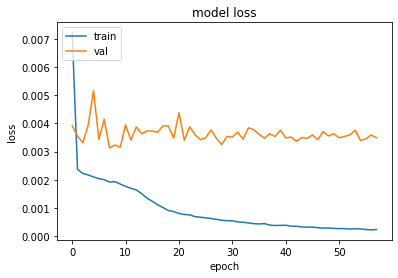

In [7]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [8]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Images count =2000
Best RMSENZ  =1926 (0.96)
Best MAENZ   =1879 (0.94)
Best PSNR    =1926 (0.96)
Best Accuracy=1620 (0.81)
RMSE-NZ  Pred=0.0498  Noisy=0.1151
MAE-NZ   Pred=0.0418  Noisy=0.0945
PSNR     Pred=12.0 dB Noisy=5.1 dB
Accuracy Pred=0.28    Noisy=0.12
SSM      Pred=0.85    Noisy=0.29
HOG MSE  Pred=0.10    Noisy=0.15


In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: E:\Projects\VenusDenoise\saves\0001_0100-64-aeconnect-xe5\assets


C:\Users\Marti\anaconda3\envs\tensor_flow\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [10]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test/
Noisy files:18
Nitid files:18
Index:0
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_06_00_0_noisy_idx068.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_06_00_0_nitid_idx076.tif


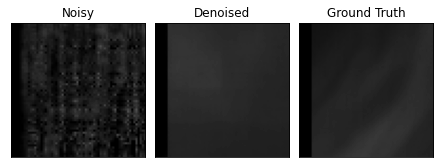

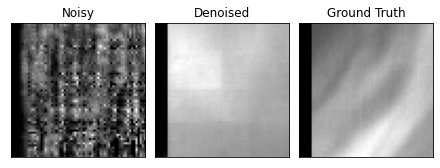

RMSE-NZ  Pred=0.0493  Noisy=0.0762 BEST
MAE-NZ   Pred=0.0386  Noisy=0.0607 BEST
PSNR     Pred=13.1 dB Noisy=9.3 dB BEST
Accuracy Pred=0.19    Noisy=0.11 BEST
SSM      Pred=0.88    Noisy=0.38
HOG MSE  Pred=0.07    Noisy=0.15
******************************************************
Index:1
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_00_9_noisy_idx068.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_00_9_nitid_idx076.tif


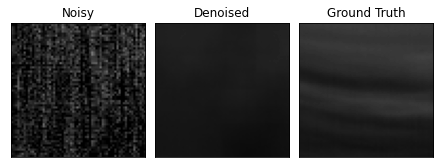

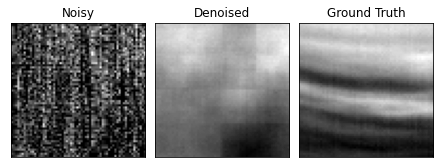

RMSE-NZ  Pred=0.0702  Noisy=0.1043 BEST
MAE-NZ   Pred=0.0601  Noisy=0.0869 BEST
PSNR     Pred=11.1 dB Noisy=7.7 dB BEST
Accuracy Pred=0.09    Noisy=0.06 BEST
SSM      Pred=0.85    Noisy=0.13
HOG MSE  Pred=0.24    Noisy=0.22
******************************************************
Index:2
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_11_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_11_nitid_idx076.tif


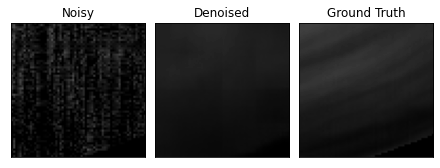

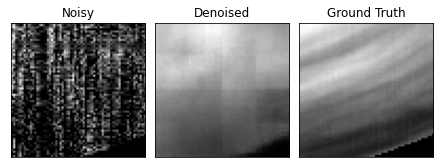

RMSE-NZ  Pred=0.0442  Noisy=0.0960 BEST
MAE-NZ   Pred=0.0357  Noisy=0.0800 BEST
PSNR     Pred=15.1 dB Noisy=8.4 dB BEST
Accuracy Pred=0.20    Noisy=0.06 BEST
SSM      Pred=0.89    Noisy=0.23
HOG MSE  Pred=0.09    Noisy=0.21
******************************************************
Index:3
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_2_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_2_nitid_idx076.tif


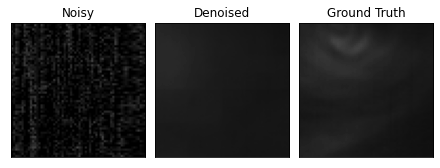

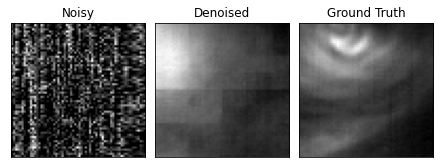

RMSE-NZ  Pred=0.0313  Noisy=0.0938 BEST
MAE-NZ   Pred=0.0225  Noisy=0.0805 BEST
PSNR     Pred=18.7 dB Noisy=9.1 dB BEST
Accuracy Pred=0.32    Noisy=0.06 BEST
SSM      Pred=0.92    Noisy=0.20
HOG MSE  Pred=0.11    Noisy=0.11
******************************************************
Index:4
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_5_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0025_07_01_5_nitid_idx076.tif


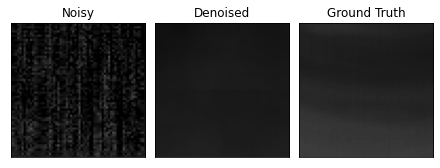

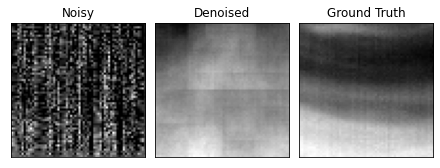

RMSE-NZ  Pred=0.0647  Noisy=0.1096 BEST
MAE-NZ   Pred=0.0549  Noisy=0.0957 BEST
PSNR     Pred=11.4 dB Noisy=6.8 dB BEST
Accuracy Pred=0.11    Noisy=0.05 BEST
SSM      Pred=0.88    Noisy=0.21
HOG MSE  Pred=0.12    Noisy=0.15
******************************************************
Index:5
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0338_05_01_10_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0338_05_01_10_nitid_idx076.tif


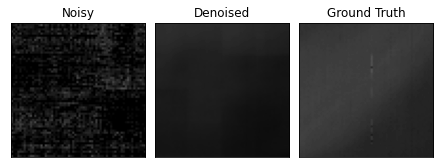

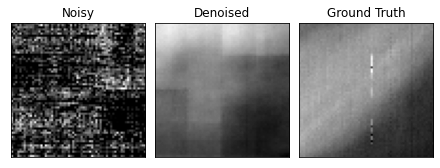

RMSE-NZ  Pred=0.1052  Noisy=0.1594 BEST
MAE-NZ   Pred=0.1008  Noisy=0.1452 BEST
PSNR     Pred=9.7 dB Noisy=6.1 dB BEST
Accuracy Pred=0.00    Noisy=0.02 WORST
SSM      Pred=0.73    Noisy=0.20
HOG MSE  Pred=0.06    Noisy=0.07
******************************************************
Index:6
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_00_15_noisy_idx068.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_00_15_nitid_idx076.tif


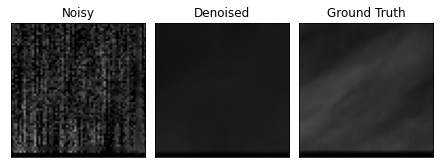

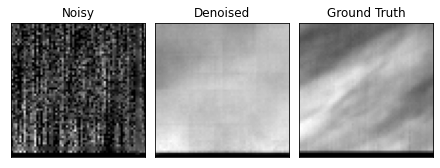

RMSE-NZ  Pred=0.0867  Noisy=0.1126 BEST
MAE-NZ   Pred=0.0774  Noisy=0.0917 BEST
PSNR     Pred=10.4 dB Noisy=8.1 dB BEST
Accuracy Pred=0.04    Noisy=0.07 WORST
SSM      Pred=0.76    Noisy=0.13
HOG MSE  Pred=0.05    Noisy=0.27
******************************************************
Index:7
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_01_7_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0361_04_01_7_nitid_idx076.tif


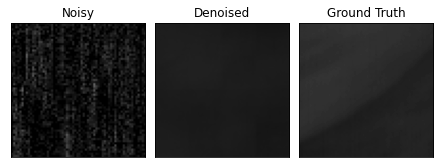

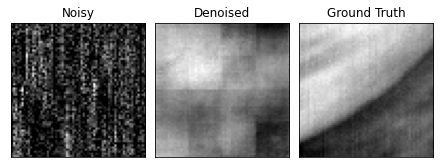

RMSE-NZ  Pred=0.0569  Noisy=0.1147 BEST
MAE-NZ   Pred=0.0507  Noisy=0.1006 BEST
PSNR     Pred=11.3 dB Noisy=5.2 dB BEST
Accuracy Pred=0.04    Noisy=0.05 WORST
SSM      Pred=0.88    Noisy=0.18
HOG MSE  Pred=0.12    Noisy=0.19
******************************************************
Index:8
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0362_04_01_15_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0362_04_01_15_nitid_idx076.tif


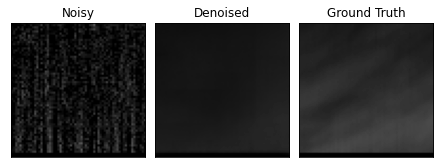

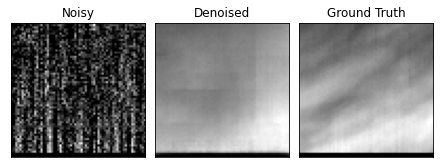

RMSE-NZ  Pred=0.0883  Noisy=0.1357 BEST
MAE-NZ   Pred=0.0802  Noisy=0.1172 BEST
PSNR     Pred=10.4 dB Noisy=6.6 dB BEST
Accuracy Pred=0.03    Noisy=0.04 WORST
SSM      Pred=0.78    Noisy=0.20
HOG MSE  Pred=0.04    Noisy=0.25
******************************************************
Index:9
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0363_00_00_0_noisy_idx068.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0363_00_00_0_nitid_idx076.tif


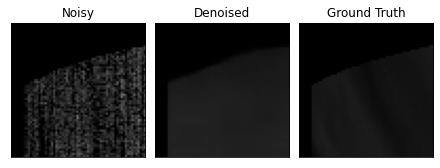

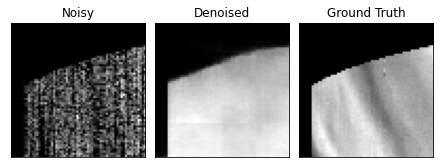

RMSE-NZ  Pred=0.0314  Noisy=0.1015 BEST
MAE-NZ   Pred=0.0236  Noisy=0.0807 BEST
PSNR     Pred=11.4 dB Noisy=1.2 dB BEST
Accuracy Pred=0.37    Noisy=0.10 BEST
SSM      Pred=0.89    Noisy=0.43
HOG MSE  Pred=0.09    Noisy=0.08
******************************************************
Index:10
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0365_00_01_9_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0365_00_01_9_nitid_idx076.tif


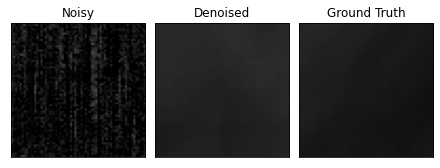

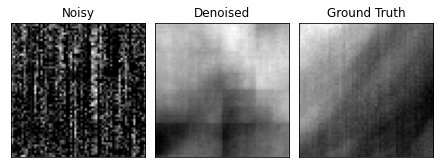

RMSE-NZ  Pred=0.0487  Noisy=0.0762 BEST
MAE-NZ   Pred=0.0441  Noisy=0.0669 BEST
PSNR     Pred=10.2 dB Noisy=6.3 dB BEST
Accuracy Pred=0.04    Noisy=0.07 WORST
SSM      Pred=0.86    Noisy=0.14
HOG MSE  Pred=0.07    Noisy=0.08
******************************************************
Index:11
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_01_01_8_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_01_01_8_nitid_idx076.tif


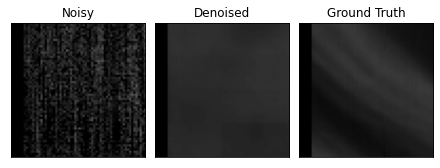

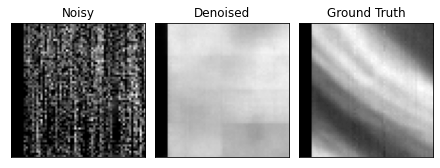

RMSE-NZ  Pred=0.0533  Noisy=0.0960 BEST
MAE-NZ   Pred=0.0398  Noisy=0.0792 BEST
PSNR     Pred=12.7 dB Noisy=7.5 dB BEST
Accuracy Pred=0.26    Noisy=0.07 BEST
SSM      Pred=0.81    Noisy=0.21
HOG MSE  Pred=0.13    Noisy=0.20
******************************************************
Index:12
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_02_01_9_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_02_01_9_nitid_idx076.tif


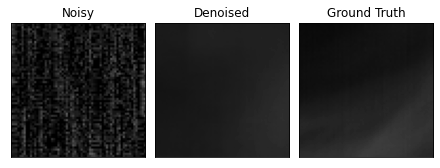

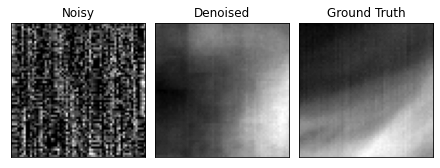

RMSE-NZ  Pred=0.0467  Noisy=0.0971 BEST
MAE-NZ   Pred=0.0402  Noisy=0.0798 BEST
PSNR     Pred=14.4 dB Noisy=8.0 dB BEST
Accuracy Pred=0.11    Noisy=0.07 BEST
SSM      Pred=0.89    Noisy=0.14
HOG MSE  Pred=0.07    Noisy=0.15
******************************************************
Index:13
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_03_00_9_noisy_idx068.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0567_03_00_9_nitid_idx076.tif


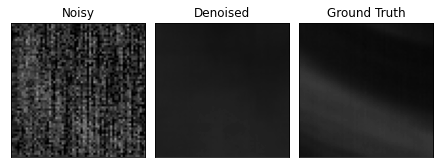

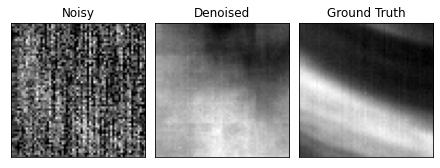

RMSE-NZ  Pred=0.0462  Noisy=0.1540 BEST
MAE-NZ   Pred=0.0416  Noisy=0.1226 BEST
PSNR     Pred=13.7 dB Noisy=3.3 dB BEST
Accuracy Pred=0.06    Noisy=0.05 BEST
SSM      Pred=0.83    Noisy=0.07
HOG MSE  Pred=0.16    Noisy=0.19
******************************************************
Index:14
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0569_02_01_11_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0569_02_01_11_nitid_idx076.tif


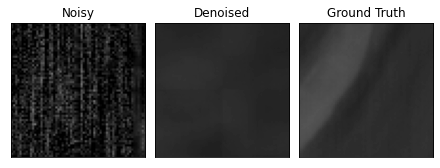

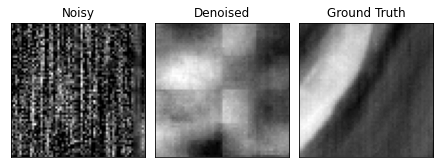

RMSE-NZ  Pred=0.0643  Noisy=0.1426 BEST
MAE-NZ   Pred=0.0470  Noisy=0.1207 BEST
PSNR     Pred=14.3 dB Noisy=7.4 dB BEST
Accuracy Pred=0.16    Noisy=0.04 BEST
SSM      Pred=0.81    Noisy=0.11
HOG MSE  Pred=0.20    Noisy=0.19
******************************************************
Index:15
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_02_01_10_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_02_01_10_nitid_idx076.tif


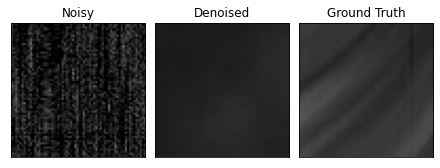

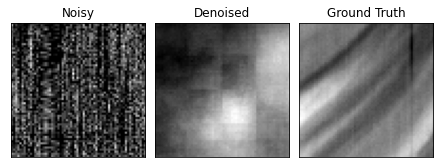

RMSE-NZ  Pred=0.0878  Noisy=0.1416 BEST
MAE-NZ   Pred=0.0767  Noisy=0.1219 BEST
PSNR     Pred=11.7 dB Noisy=7.5 dB BEST
Accuracy Pred=0.05    Noisy=0.04 BEST
SSM      Pred=0.70    Noisy=0.12
HOG MSE  Pred=0.16    Noisy=0.27
******************************************************
Index:16
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_03_00_11_noisy_idx068.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0571_03_00_11_nitid_idx076.tif


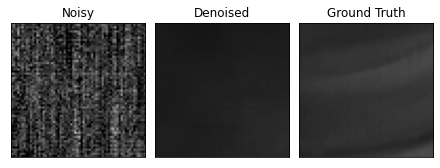

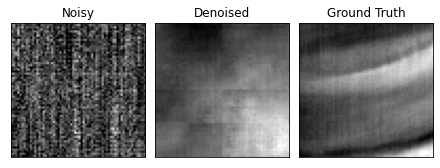

RMSE-NZ  Pred=0.0824  Noisy=0.1312 BEST
MAE-NZ   Pred=0.0771  Noisy=0.1051 BEST
PSNR     Pred=11.3 dB Noisy=7.2 dB BEST
Accuracy Pred=0.01    Noisy=0.05 WORST
SSM      Pred=0.83    Noisy=0.06
HOG MSE  Pred=0.11    Noisy=0.18
******************************************************
Index:17
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0706_02_01_3_noisy_idx089.tif
E:/Projects/VenusDenoise/dataset/cases/64/0001_0100/test\VI0706_02_01_3_nitid_idx076.tif


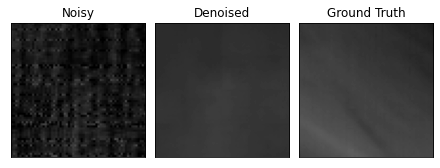

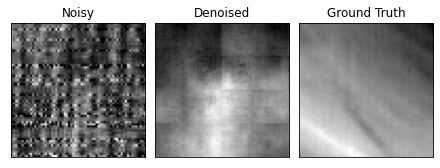

RMSE-NZ  Pred=0.0597  Noisy=0.1634 BEST
MAE-NZ   Pred=0.0489  Noisy=0.1488 BEST
PSNR     Pred=15.7 dB Noisy=7.0 dB BEST
Accuracy Pred=0.12    Noisy=0.01 BEST
SSM      Pred=0.85    Noisy=0.28
HOG MSE  Pred=0.13    Noisy=0.12
******************************************************


In [11]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
                dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
                dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )